#### <h1 align=center><font size = 5>Capstone Project -18 : Crop Recommendation System</font></h1>
<h2 align=center><font size = 5>AIML Certification Programme</font></h2>

## Team <br>
1. Anuj Alex (2024AIML009)​
2. Gurbachan Singh Kalwan (2024AIML004)​
3. Krishna Murthy P (2024AIML078)​
4. Sidharth Gupta (2024AIML017)
5. Sree Rama Kumar Yeddanapudi (2024AILML008)​

Mentor: Prof. Aniruddha Dasgupta

In [2]:
import numpy as np # linear algebra
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import re
from rapidfuzz import process, fuzz

### 1. Loading and Reading Dataset

In [3]:
df = pd.read_csv("data/AP_data.csv")
df.rename(columns={"Extent\n(AC)":"Farm_Acres","Crop before":"Crop_Sown"},inplace=True)
df['District'] = df['District'].replace({
    "Anantapur": "Ananthapur",
    "S.P.S.Nellore": "Nellore",
    "S.P.S. Nellore": "Nellore",
    "Kadapa YSR": "Kadapa"
})
df.head()

,Sl no,Date,Farmer No,Macro/ Micro nutrient,Farmer Name,District,Mandal,Village,Latitude,Longitude,...,Avail-Mg,Avail-S,Avail-Zn,Avail-B,Avail-Fe,Avail-Cu,Avail-Mn,Time,Season,Recommended Sowing Time
0,1.0,1/1/2015,1910,RK2276,P.Krishna Naik,Ananthapur,Penukonda,Gonipeta,14.08,77.69,...,101.0,5.16,0.30,0.17,8.89,0.51,15.24,1/1/2015,Kharif & Rabi,Kharif: June - July & Rabi: October - November
1,2.0,1/1/2015,1911,RK2277,Kallu Thippe Naik,Ananthapur,Penukonda,Gonipeta,14.09,77.69,...,261.0,9.91,0.36,0.57,3.24,0.44,6.90,1/1/2015,Kharif & Rabi,Kharif: June - July & Rabi: October - November
2,3.0,1/1/2015,1912,RK2278,P.Duble Bai,Ananthapur,Penukonda,Gonipeta,14.09,77.69,...,48.0,3.77,0.37,0.19,5.54,0.42,8.34,1/1/2015,Kharif & Rabi,Kharif: June - July & Rabi: October - November
3,4.0,1/1/2015,1913,RK2279,H.Marekka (Kamma),Ananthapur,Penukonda,Gonipeta,14.10,77.70,...,52.0,4.14,0.23,0.21,1.79,0.67,4.17,1/1/2015,Rabi,September - October
4,5.0,1/1/2015,1914,RK2280,M.Alevelamma,Ananthapur,Penukonda,Gonipeta,14.09,77.69,...,84.0,1.45,0.36,0.22,22.26,0.45,9.20,1/1/2015,Rabi,September - October


In [4]:
dist_master = pd.read_csv("data/AP_district_level_master.csv")
dist_master.head()

,State,District,Soil_Percent,N_per_Ha,P_per_Ha,K_per_Ha,Kharif_rain,Rabi_rain,Zaid_rain,Area,Rank,Stand_Soil,Stand_Crop
0,Andhra Pradesh,Ananthapur,100.0,27.71,17.96,6.99,272.0,148.0,77.0,594.740,1.0,Sandy,['Groundnut']
1,Andhra Pradesh,Ananthapur,100.0,27.71,17.96,6.99,272.0,148.0,77.0,586.860,2.0,Sandy,['Other']
2,Andhra Pradesh,Ananthapur,100.0,27.71,17.96,6.99,272.0,148.0,77.0,51.825,3.0,Sandy,['Rice']
3,Andhra Pradesh,Ananthapur,100.0,27.71,17.96,6.99,272.0,148.0,77.0,43.055,4.0,Sandy,['Other']
4,Andhra Pradesh,Ananthapur,100.0,27.71,17.96,6.99,272.0,148.0,77.0,24.800,5.0,Sandy,['Pigeonpea']


### 1.1 Merge datasets

In [5]:
# Merge the DataFrames using left_on and right_on
rain_df= dist_master[["District","Kharif_rain",	"Rabi_rain",	"Zaid_rain"]].drop_duplicates()
# print(rain_df.head())
merged_df = pd.merge(df,rain_df, left_on='District', right_on='District',how='left')

### 1.2 Remove unnecessary columns

In [6]:
merged_df.drop(columns=["Sl no", "Date", "Farmer No", "Macro/ Micro nutrient", "Farmer Name", "Fathers Name", "Time"
                        , "Recommended Sowing Time", "Season", "Farm_Acres", "Survey No.","Latitude","Longitude"], inplace=True)

In [7]:
orig_df = df
df = merged_df

### 1.3 Check basic data statistics (shape, info, describe)

In [8]:
df.shape

(4816, 21)

In [9]:
df.describe()

,pH,EC,Avail-P,Exch-K,Avail-Ca,Avail-Mg,Avail-Zn,Avail-Fe,Avail-Cu,Avail-Mn,Kharif_rain,Rabi_rain,Zaid_rain
count,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000,4815.000000
mean,7.477844,0.489531,16.704285,159.676012,2416.086604,522.878920,1.111973,28.349657,2.533325,18.805155,503.790447,311.759917,74.812461
std,1.052134,1.045581,18.810818,135.616280,2155.234533,473.764527,1.396243,38.578050,3.061383,18.965475,169.263499,151.074131,19.353745
min,4.150000,0.010000,0.450000,12.000000,20.000000,2.000000,0.030000,0.040000,0.030000,0.010000,272.000000,125.000000,49.000000
25%,6.740000,0.110000,5.160000,82.000000,839.000000,184.000000,0.410000,5.780000,0.930000,8.100000,404.000000,235.000000,55.000000
50%,7.810000,0.220000,10.930000,129.000000,1652.000000,374.000000,0.700000,12.210000,1.460000,12.960000,455.000000,270.000000,70.000000
75%,8.270000,0.510000,21.410000,196.000000,3150.500000,715.500000,1.250000,33.980000,2.600000,22.125000,699.000000,375.000000,94.000000
max,9.890000,27.500000,361.940000,2409.000000,13304.000000,5363.000000,23.920000,354.700000,20.180000,256.880000,806.000000,710.000000,109.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4816 entries, 0 to 4815
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   District     4815 non-null   object 
 1   Mandal       4815 non-null   object 
 2   Village      4815 non-null   object 
 3   Soil type    4749 non-null   object 
 4   Crop_Sown    4595 non-null   object 
 5   pH           4815 non-null   float64
 6   EC           4815 non-null   float64
 7   OC           4815 non-null   object 
 8   Avail-P      4815 non-null   float64
 9   Exch-K       4815 non-null   float64
 10  Avail-Ca     4815 non-null   float64
 11  Avail-Mg     4815 non-null   float64
 12  Avail-S      4815 non-null   object 
 13  Avail-Zn     4815 non-null   float64
 14  Avail-B      4815 non-null   object 
 15  Avail-Fe     4815 non-null   float64
 16  Avail-Cu     4815 non-null   float64
 17  Avail-Mn     4815 non-null   float64
 18  Kharif_rain  4815 non-null   float64
 19  Rabi_r

In [11]:
cols_to_convert = ['OC', 'Avail-S', 'Avail-B']
for col in cols_to_convert:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

### 1.4 Display unique and sample values for columns

In [12]:
for col in df.columns:
    print(col, df[col].nunique(),df[col].unique()[0:20],'\n')

District 13 ['Ananthapur' 'Chittoor' 'East Godavari' 'Guntur' 'Kadapa' 'Krishna'
 'Kurnool' 'Nellore' 'Prakasam' 'Srikakulam' 'Visakhapatnam'
 'Vizianagaram' 'West Godavari' nan] 

Mandal 31 ['Penukonda' 'Raptadu' 'Santipuram' 'V.Kota' 'Gangavaram' 'Kollur'
 'Sattenapalli' 'B Mattam' 'Porumamilla' 'Sambepalli' 'Veeraballi'
 'G Konduru' 'Ghantasala' 'Banaganpalli' 'Devanakonda' 'Indukurpeta'
 'Podalakuru' 'T.P.Gudur' 'Kanigiri' 'Konakana Mitta'] 

Village 251 ['Gonipeta' 'Kondampalli' 'Settipalli' 'G.Koythapally' 'Gandlaparthi'
 'Gollapalli' 'Palbhavi' 'Pesarakunta' 'Pullalarevu' 'Raminepally'
 '121.Pedduru' '30.Sonneganipalle' 'Bellakogilla' 'Bendamakuppam'
 'Chinnaridoddi' 'Dandikuppam' 'Kadapalle' 'Kenumakulapalle'
 'Konerukuppam' 'Settiballa'] 

Soil type 99 ['Mixed soil' 'Redsoil' 'Sandi soil' 'Red soil' 'Black Soil' 'Sandy soil'
 'RED' 'BLACK' nan 'SAND' 'Red' 'Black' 'red' 'Rock soil' '-' 'Sandy Red'
 'Red Sandy' 'Sandy' 'Black Sandy' 'Claim'] 

Crop_Sown 129 ['Ground Nut' 'Horse

### 2. Data Preprocessing

### 2.1 Check for Data Quality Issues

* duplicate data
* missing data
* data inconsistencies

In [13]:
# duplicate data
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 1


In [14]:
# missing data
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
print(missing_data.sort_values(ascending = False))

Crop_Sown      221
Soil type       67
OC               3
Avail-S          2
Avail-B          2
Mandal           1
Village          1
District         1
EC               1
Avail-P          1
Exch-K           1
Avail-Ca         1
pH               1
Avail-Mg         1
Avail-Zn         1
Avail-Fe         1
Avail-Cu         1
Avail-Mn         1
Kharif_rain      1
Rabi_rain        1
Zaid_rain        1
dtype: int64


### 2.2 Handle missing values for numerical attributes

In [15]:
numerical_cols = df.select_dtypes(include=['float64','int64']).columns

In [16]:
numerical_cols

Index(['pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-Ca', 'Avail-Mg',
       'Avail-S', 'Avail-Zn', 'Avail-B', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn',
       'Kharif_rain', 'Rabi_rain', 'Zaid_rain'],
      dtype='object')

In [17]:
for col in numerical_cols:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

In [18]:
# missing data
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
print(missing_data.sort_values(ascending = False))

Crop_Sown    221
Soil type     67
District       1
Village        1
Mandal         1
dtype: int64


### 2.3 Handle missing values for Soil

In [19]:
# --- Master Soil categories ---
master_categories = [
    "Black", "Red", "Sandy", "Loam", "Clay",
    "Brown", "Yellow", "White", "Laterite",
    "Saline", "Alkaline", "Alluvial",
    "Gravel/Stony", "Mixed", "Other"
]

# --- Known corrections / synonyms ---
direct_map = {
    # Misspellings
    "RED": "Red",
    "red": "Red",
    "Red soil": "Red",
    "res": "Red",
    "redsoil": "Red",
    "redsoils": "Red",
    "red sandy loam": "Red",
    "red sandy": "Red",
    "red sandy\\": "Red",
    "redsandy": "Red",
    "redsandylo": "Red",
    "redsand": "Red",
    "redloam": "Red",
    "redbrown": "Red",
    "red grey": "Red",
    "red masari": "Red",

    "black soil": "Black",
    "Black Soil": "Black",
    "BLACK": "Black",
    "black clay": "Black",
    "black sandy": "Black",
    "black sandy loam": "Black",
    "black loam": "Black",
    "deepblack": "Black",
    "deep black": "Black",
    "normal bla": "Black",
    "black mix": "Black",
    "black mara": "Black",


    "sandi": "Sandy",
    "sanday": "Sandy",
    "sanday+bla": "Sandy",
    "sanday mix": "Sandy",
    "sand mixed": "Sandy",
    "sand mix": "Sandy",
    "sandy loam": "Sandy",
    "sandy mixe": "Sandy",
    "sandy with": "Sandy",
    "sandy brow": "Sandy",
    "sandy whit": "Sandy",


    "clayey loam": "Clay",
    "clay soil": "Clay",
    "caly soil": "Clay",
    "clay-sandy": "Clay",
    "silty clay": "Clay",

    "broan clay": "Brown",
    "brown light": "Brown",
    "brown dark": "Brown",
    "light brow": "Brown",
    "dark brown": "Brown",

    "alkhaline": "Alkaline",
    "alkline": "Alkaline",
    "alkline +": "Alkaline",
    "black alka": "Alkaline",

    "saline soi": "Saline",
    "salain": "Saline",
    "salty": "Saline",
    "salain mix": "Saline",
    "saline mix": "Saline",

    "laterite s": "Laterite",
    "laterite l": "Laterite",
    "laterite m": "Laterite",
    "laterite u": "Laterite",
    "latritate": "Laterite",
    "red lateri": "Laterite",

    "loamy soil": "Loam",
    "loomy": "Loam",
    "loami": "Loam",
    "laomy": "Loam",
    "soil loamy": "Loam",
    "loamy brow": "Loam",
    "ORTHIDS": "Loam",

    "white gara": "White",
    "white mixe": "White",
    "white soil": "White",
    "whitebrown": "White",
    "white sand": "White",
    "white red": "White",
    "white yell": "White",
    "brown whit": "White",

    "yellowblac": "Yellow",
    "yellowbrow": "Yellow",
    "yellow red": "Yellow",
    "white yello": "Yellow",

    # Loam/Alluvial
    "alluvial s": "Alluvial",
}
direct_map.update({
    # Sandy soils
    "SANDY ALFISOL": "Sandy",
    "SANDY ALFISOLS": "Sandy",
    "PSSAMENTS": "Sandy",
    "PSSAMNETS": "Sandy",
    "INNCEPTISOLS": "Sandy",
    "INSEPTISOLS": "Sandy",

    # Loam soils / Alfisols / Inceptisols variants
    "ORTHIDS": "Loam",
    "LOAMY ALFISOLS": "Loam",
    "LOAMY ALFISOL": "Loam",
    "USTALF/USTOLLS": "Loam",
    "UDUPTS/UDALFS": "Loam",
    "UDOLLS/UDALFS": "Loam",
    "INCEPTISOLS": "Loam",

    # Black soils / Vertisols variants
    "VERTISOLS": "Black",
    "VERTIC SOILS": "Black",
    "VERTIC SOLS": "Black",
    "VERTI SOLS": "Black",
    "VRTIC SOILS": "Black",
    "VERRTISOLS": "Black",
    "VERTIC OSILS": "Black",
})
# --- Local overrides (dialect → base class) ---
overrides = {
    "chowdu": "Red",
    "nalla regadi": "Red",
    "regadi": "Red",
    "sowdu": "Red",
    "sudda": "Red",
    "thella kattu": "Red",
    "sudda neela": "Red",
    "tella masaka": "Red",
    "erra maska": "Red",
    "savudu": "Red",
    "garuku": "Other",
    "garasu": "Red",
    "garasu mix": "Red",
    "garsu mix": "Red",
    "mosari": "Red",
    "masari": "Red",
    "masali": "Red",
    "masale": "Red",
    "masori": "Red",
    "madikattu": "Red",
    "maradi": "Red",
    "marad": "Red",
    "mardi": "Red",
    "marali": "Red",
    "moram": "Red",
    "maralugodu": "Red",

    "murrum": "Black",
    "murum soil": "Black",
    "medium bla": "Black",
    "m black": "Black",
    "black muri": "Black",
    "humpli bla": "Black",

    "kari": "Black",
    "kapu": "Black",
    "kappu": "Black",

    "kemp": "Red",
    "kempu": "Red",
    "k-r": "Red",
    "r-k": "Red",
    "r-m": "Red",
    "m-r": "Red",
}

In [20]:
print(master_categories)

['Black', 'Red', 'Sandy', 'Loam', 'Clay', 'Brown', 'Yellow', 'White', 'Laterite', 'Saline', 'Alkaline', 'Alluvial', 'Gravel/Stony', 'Mixed', 'Other']


In [21]:
print(direct_map)

{'RED': 'Red', 'red': 'Red', 'Red soil': 'Red', 'res': 'Red', 'redsoil': 'Red', 'redsoils': 'Red', 'red sandy loam': 'Red', 'red sandy': 'Red', 'red sandy\\': 'Red', 'redsandy': 'Red', 'redsandylo': 'Red', 'redsand': 'Red', 'redloam': 'Red', 'redbrown': 'Red', 'red grey': 'Red', 'red masari': 'Red', 'black soil': 'Black', 'Black Soil': 'Black', 'BLACK': 'Black', 'black clay': 'Black', 'black sandy': 'Black', 'black sandy loam': 'Black', 'black loam': 'Black', 'deepblack': 'Black', 'deep black': 'Black', 'normal bla': 'Black', 'black mix': 'Black', 'black mara': 'Black', 'sandi': 'Sandy', 'sanday': 'Sandy', 'sanday+bla': 'Sandy', 'sanday mix': 'Sandy', 'sand mixed': 'Sandy', 'sand mix': 'Sandy', 'sandy loam': 'Sandy', 'sandy mixe': 'Sandy', 'sandy with': 'Sandy', 'sandy brow': 'Sandy', 'sandy whit': 'Sandy', 'clayey loam': 'Clay', 'clay soil': 'Clay', 'caly soil': 'Clay', 'clay-sandy': 'Clay', 'silty clay': 'Clay', 'broan clay': 'Brown', 'brown light': 'Brown', 'brown dark': 'Brown', 'l

In [22]:
def clean_text(txt: str) -> str:
    txt = str(txt).lower().strip()
    txt = re.sub(r"soil", "", txt)
    txt = re.sub(r"[^a-z\s\+\-]", "", txt)
    return txt.strip()

In [23]:
def standardize_soil(raw: str) -> str:
    # if not raw or not isinstance(raw, str) or raw.strip() == "":
    #     return "Other"
    # text = raw.lower()
    text = clean_text(raw)
    for key, val in overrides.items():
        if key in text:
            return val
    for key, val in direct_map.items():
        if key in text:
            return val
    # if text in direct_map:
    #     return direct_map[text]

    match, score, _ = process.extractOne(text, master_categories, scorer=fuzz.WRatio)
    if score >= 80:
        return match
    return "Other"

In [24]:
# def standardize_soil(raw: str) -> str:
#     if not raw or not isinstance(raw, str) or raw.strip() == "":
#         return "Other"

#     text = clean_text(raw)
#     for key, val in overrides.items():
#         if key in text:
#             return val
#     if text in direct_map:
#         return direct_map[text]

#     match, score, _ = process.extractOne(text, master_categories, scorer=fuzz.WRatio)
#     if score >= 80:
#         return match
#     return "Other"

In [25]:
# Test Soil Function works for samples
samples = [
    "Black Soil", "redsoil", "Chowdu", "Alkline +",
    "Saline Soi", "Laterite m", "Broan Clay",
    "Sanday+bla", "White gara", "Masari", "Murum Soil",
    "nalla regadi", "redsandylo", "Random Gibberish", "", None
    ,"RED", "BLACK", "Red soil", "Black Soil"

]

print("--- Soil Type Standardization Examples ---")
for s in samples:
    # For each sample, print the original string and its standardized version
    standardized_value = standardize_soil(s)
    print(f"'{s}' → '{standardized_value}'")

--- Soil Type Standardization Examples ---
'Black Soil' → 'Black'
'redsoil' → 'Red'
'Chowdu' → 'Red'
'Alkline +' → 'Alkaline'
'Saline Soi' → 'Saline'
'Laterite m' → 'Laterite'
'Broan Clay' → 'Brown'
'Sanday+bla' → 'Sandy'
'White gara' → 'White'
'Masari' → 'Red'
'Murum Soil' → 'Other'
'nalla regadi' → 'Red'
'redsandylo' → 'Red'
'Random Gibberish' → 'Other'
'' → 'Other'
'None' → 'Other'
'RED' → 'Red'
'BLACK' → 'Black'
'Red soil' → 'Red'
'Black Soil' → 'Black'


### 2.4 Handle missing values for Crop

In [26]:
crop_map = {
    # Cereals (Grains & Millets)
    "maize": "Maize", "mazi": "Maize", "sweetcorn": "Maize",
    "jowar": "Sorghum", "jonna": "Sorghum", "mahendra jonna": "Sorghum",
    "pacha jonna": "Sorghum", "erra jonna": "Sorghum",
    "bajra": "Pearl Millet",
    "korra": "Foxtail Millet",
    "dhanyalu": "Other Millet",
    "ragi": "Ragi",
    "vari": "Rice", "paddy": "Rice", "paady": "Rice",
    "rice": "Rice",
    "millet": "Other Millet",
    "finger millet": "Ragi",
    "pearl millet": "Pearl Millet",
    "wheat": "Wheat",
    "barley": "Barley",

    # Pulses
    "bengalgram": "Chickpea", "senaga": "Chickpea", "erra senaga": "Chickpea",
    "chickpea": "Chickpea",
    "red gram": "Pigeonpea", "redgram": "Pigeonpea",
    "pigeonpea": "Pigeonpea",
    "green gram": "Green Gram", "mung": "Green Gram",
    "black gram": "Black Gram", "blackgram": "Black Gram",
    "horse gram": "Horse Gram", "horsegram": "Horse Gram",
    "cowpea": "Cowpea", "cow pea": "Cowpea",
    "rajma": "Rajma", "peasara": "Other Pulse", "pulse": "Other Pulse",
    "minor pulses": "Other Pulse",

    # Oilseeds
    "ground nut": "Groundnut", "groundnut": "Groundnut", "g.nut": "Groundnut",
    "grounat": "Groundnut", "ground nat": "Groundnut",
    "veru senaga": "Groundnut",
    "castor": "Castor", "clastor": "Castor",
    "sesamum": "Sesame", "sesumum": "Sesame",
    "sunflower": "Sunflower",
    "linseed": "Linseed",
    "rapeseed": "Rapeseed and Mustard", "mustard": "Rapeseed and Mustard",
    "soyabean": "Soyabean", "soybean": "Soyabean",
    "safflower": "Safflower",

    # Cash crops
    "cotton": "Cotton", "cottan": "Cotton",
    "sugarcane": "Sugarcane", "suger cane": "Sugarcane",
    "sugar cane": "Sugarcane",
    "tobacco": "Tobacco", "pogaku": "Tobacco",
    "oil palm": "Oil Palm",
    "eucalyptus": "Eucalyptus", "eucaliptus": "Eucalyptus",

    # Fruits
    "banana": "Banana", "cocnut": "Coconut", "coconut": "Coconut",
    "papaya": "Papaya", "anaar": "Pomegranate",
    "mango": "Mango",
    "citrus": "Citrus",
    "lime": "Lime", "lemon": "Lime",
    "cashew": "Cashew", "cashewnut": "Cashew", "cashew nut": "Cashew",
    "cashew raina": "Cashew",
    "cocoa": "Cocoa", "cocoa+ coconut": "Cocoa",
    "fruits": "Fruits",

    # Vegetables
    "brinjal": "Brinjal",
    "tomato": "Tomato", "tamato": "Tomato",
    "benda": "Okra", "okra": "Okra",
    "cabbage": "Cabbage", "cabage": "Cabbage",
    "cucumber": "Cucumber",
    "potato": "Potato", "potatao": "Potato", "potatoes": "Potato",
    "onion": "Onion", "onian": "Onion", "oniyan": "Onion",
    "ridge guard": "Ridge Gourd", "donda": "Ridge Gourd",
    "yam": "Yam",
    "vegetable": "Vegetables", "vegetables": "Vegetables",

    # Spices & condiments
    "chilli": "Chilli", "chill": "Chilli", "chillies": "Chilli",
    "chilly": "Chilli", "mirchi": "Chilli",
    "turmeric": "Turmeric", "turmaric": "Turmeric",
    "coriandam": "Coriander",

    # Plantation crops
    "mulberry": "Mulberry", "mulbarry": "Mulberry", "mulberrry": "Mulberry",
    "coffee": "Coffee",
    "red sandal": "Sandalwood", "sandal": "Sandalwood",

    # Others
    "fodder crops": "Fodder", "fodder": "Fodder",
    "flowers": "Flowers",
    "prawns": "Aquaculture",
}

In [27]:
def standardize_crop(raw: str) -> list[str]:
    if not isinstance(raw, str) or not raw.strip(): return ["Other"]
    text = raw.lower()
    text = re.sub(r'[/;()$$$$+]', ',', text)
    text = re.sub(r'\b(intercrop|and|crops?)\b', ',', text, flags=re.IGNORECASE)
    potential_crops = [c.strip() for c in text.split(',') if c.strip()]
    standardized_crops = set()
    for crop_text in potential_crops:
        if crop_text in crop_map:
            standardized_crops.add(crop_map[crop_text])
            continue
        match, score, _ = process.extractOne(crop_text, crop_map.keys(), scorer=fuzz.WRatio)
        if score >= 85:
            standardized_crops.add(crop_map[match])
    if not standardized_crops: return ["Other"]
    return sorted(list(standardized_crops))

In [28]:
# # Test Crop Function works for samples
# tests = [
#     "Cashewnut, Mango (Intercrop Maize And Seasamum)",
#     "Topioca, Cashew",
#     "Paddy/Maize/G.Nut",
#     "Cotton;Red Gram",
#     "Oil Palm+Coconut",
#     "Paddy/ Sugarcane",
#     "Mirchi",
#     "Erra Senaga"
# ]

# for t in tests:
#     print(t, "→", standardize_crop(t))

In [29]:
ranked_soil_crop_map = {
    "Black": {1: ["Cotton", "Sorghum", "Pigeonpea"], 2: ["Sunflower", "Chilli", "Soybean", "Pomegranate"], 3: ["Groundnut", "Sugarcane"]},
    "Red": {1: ["Groundnut", "Castor", "Horse Gram", "Pigeonpea"], 2: ["Sorghum", "Foxtail Millet", "Pearl Millet", "Tomato", "Chilli"], 3: ["Mango", "Cashew", "Mulberry"]},
    "Loam": {1: ["Paddy", "Maize", "Groundnut", "Sunflower"], 2: ["Banana", "Tomato", "Brinjal", "Onion", "Potato"], 3: ["Sugarcane", "Turmeric", "Coriander"]},
    "Alluvial": {1: ["Paddy", "Sugarcane", "Maize"], 2: ["Banana", "Potato", "Onion", "Brinjal"], 3: ["Groundnut", "Pulses", "Papaya"]},
    "Laterite": {1: ["Coconut", "Cashew", "Coffee"], 2: ["Mango", "Oil Palm", "Eucalyptus"], 3: ["Sandalwood"]},
    "Sandy": {1: ["Groundnut", "Cowpea", "Castor"], 2: ["Watermelon", "Cucumber", "Vegetables"], 3: ["Sunflower", "Sesamum"]},
    "Clay": {1: ["Paddy"], 2: ["Sugarcane"], 3: ["Banana"]},
    "Saline": {1: ["Cotton"], 2: ["Paddy"], 3: ["Eucalyptus"]},
    "Alkaline": {1: ["Cotton"], 2: ["Paddy"], 3: ["Eucalyptus"]},
}

In [30]:
def get_ranked_crops(soil):
    return ranked_soil_crop_map.get(soil, {})

In [31]:
# def get_crop_recommendations(soil_type_raw: str):
#     """
#     Standardizes a raw soil type and provides ranked crop recommendations.
#     """
#     # 1. Standardize the input soil type
#     standardized_soil = standardize_soil(soil_type_raw)
#     print(f"Input Soil: '{soil_type_raw}' → Standardized as: '{standardized_soil}'")

#     # 2. Retrieve the ranked list of crops
#     recommendations = get_ranked_crops(standardized_soil)

#     # 3. Display the results
#     if not recommendations:
#         print(f"-> No specific crop recommendations found for '{standardized_soil}' soil.")
#     else:
#         print("-> Crop Recommendations:")
#         for rank, crops in sorted(recommendations.items()):
#             rank_desc = {1: "Most Suitable", 2: "Moderately Suitable", 3: "Less Suitable"}
#             print(f"  - Rank {rank} ({rank_desc.get(rank, '')}): {', '.join(crops)}")

# # --- Example Usage ---
# print("\n--- Crop Recommendation Example ---")
# get_crop_recommendations("Nalla Regadi")

In [32]:
# 2. Standardize Soil Type
df['Soil_Type_Standard'] = df['Soil type'].apply(standardize_soil)
df['Crop_Sown_Standard'] = df['Crop_Sown'].apply(standardize_crop)

In [33]:
df.drop(columns=["Soil type", "Crop_Sown"], inplace=True)

In [34]:
# missing data
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0]
print(missing_data.sort_values(ascending = False))

District    1
Mandal      1
Village     1
dtype: int64


### 3. Exploratory Data Analysis

### 3.1 EDA - Soil Distribution

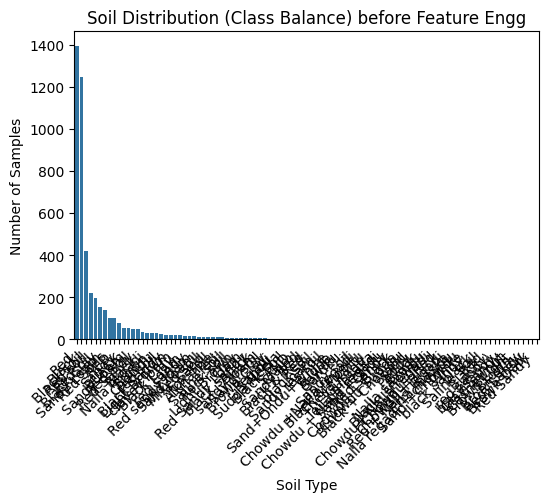

In [35]:
plt.figure(figsize=(6, 4))
soil_counts_orig = orig_df['Soil type'].value_counts()
sns.barplot(x=soil_counts_orig.index, y=soil_counts_orig.values)
plt.title('Soil Distribution (Class Balance) before Feature Engg')
plt.xlabel('Soil Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.show()

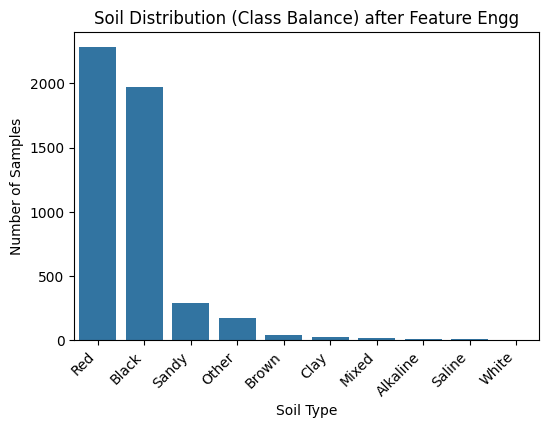

In [36]:
plt.figure(figsize=(6, 4))
soil_counts = df['Soil_Type_Standard'].value_counts()
sns.barplot(x=soil_counts.index, y=soil_counts.values)
plt.title('Soil Distribution (Class Balance) after Feature Engg')
plt.xlabel('Soil Type')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.show()

### 3.2 EDA - Crop Distribution

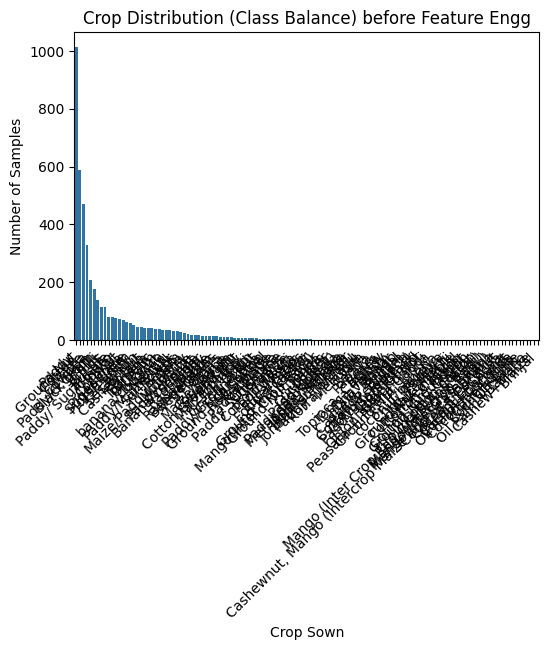

In [37]:
plt.figure(figsize=(6, 4))
soil_counts_orig = orig_df['Crop_Sown'].value_counts()
sns.barplot(x=soil_counts_orig.index, y=soil_counts_orig.values)
plt.title('Crop Distribution (Class Balance) before Feature Engg')
plt.xlabel('Crop Sown')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.show()

In [38]:
# Extract first element from each list
df['First_Crop'] = df['Crop_Sown_Standard'].apply(lambda x: x[0] if isinstance(x, list) and x else None)
df_EDA = df
df.drop(columns=["Crop_Sown_Standard"], inplace=True)

In [39]:
top_25_crops = df['First_Crop'].value_counts().head(25).index.tolist()

# Replace crops not in top 5 with 'others'
df['First_Crop'] = df['First_Crop'].apply(lambda x: x if x in top_25_crops else 'Other')

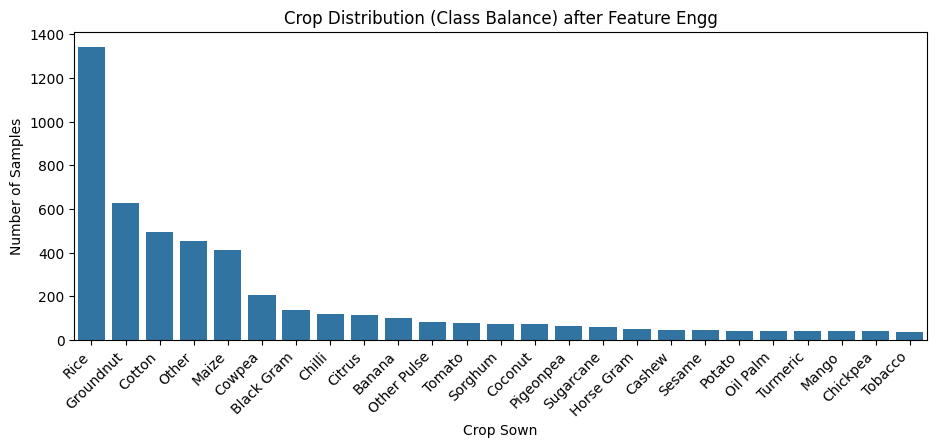

In [40]:
plt.figure(figsize=(11, 4))
crop_counts = df['First_Crop'].value_counts()
sns.barplot(x=crop_counts.index, y=crop_counts.values)
plt.title('Crop Distribution (Class Balance) after Feature Engg')
plt.xlabel('Crop Sown')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.show()

In [41]:
# # Set plotting style
# sns.set(style="whitegrid")

# # ✔ Distribution of Nutrients
# print("\n--- EDA: Distribution of Nutrients ---")
# # Update nutrient_cols to match the columns in df_processed (using hyphens)
# nutrient_cols = ['pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-S', 'Avail-Zn', 'Avail-B', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn']

# plt.figure(figsize=(15, 12))
# for i, col in enumerate(nutrient_cols):
#     plt.subplot(4, 3, i + 1) # Adjust subplot layout
#     sns.histplot(df[col], kde=True, bins=20) # Use df_processed instead of data
#     plt.title(f'Distribution of {col}')
# plt.tight_layout()
# plt.show()

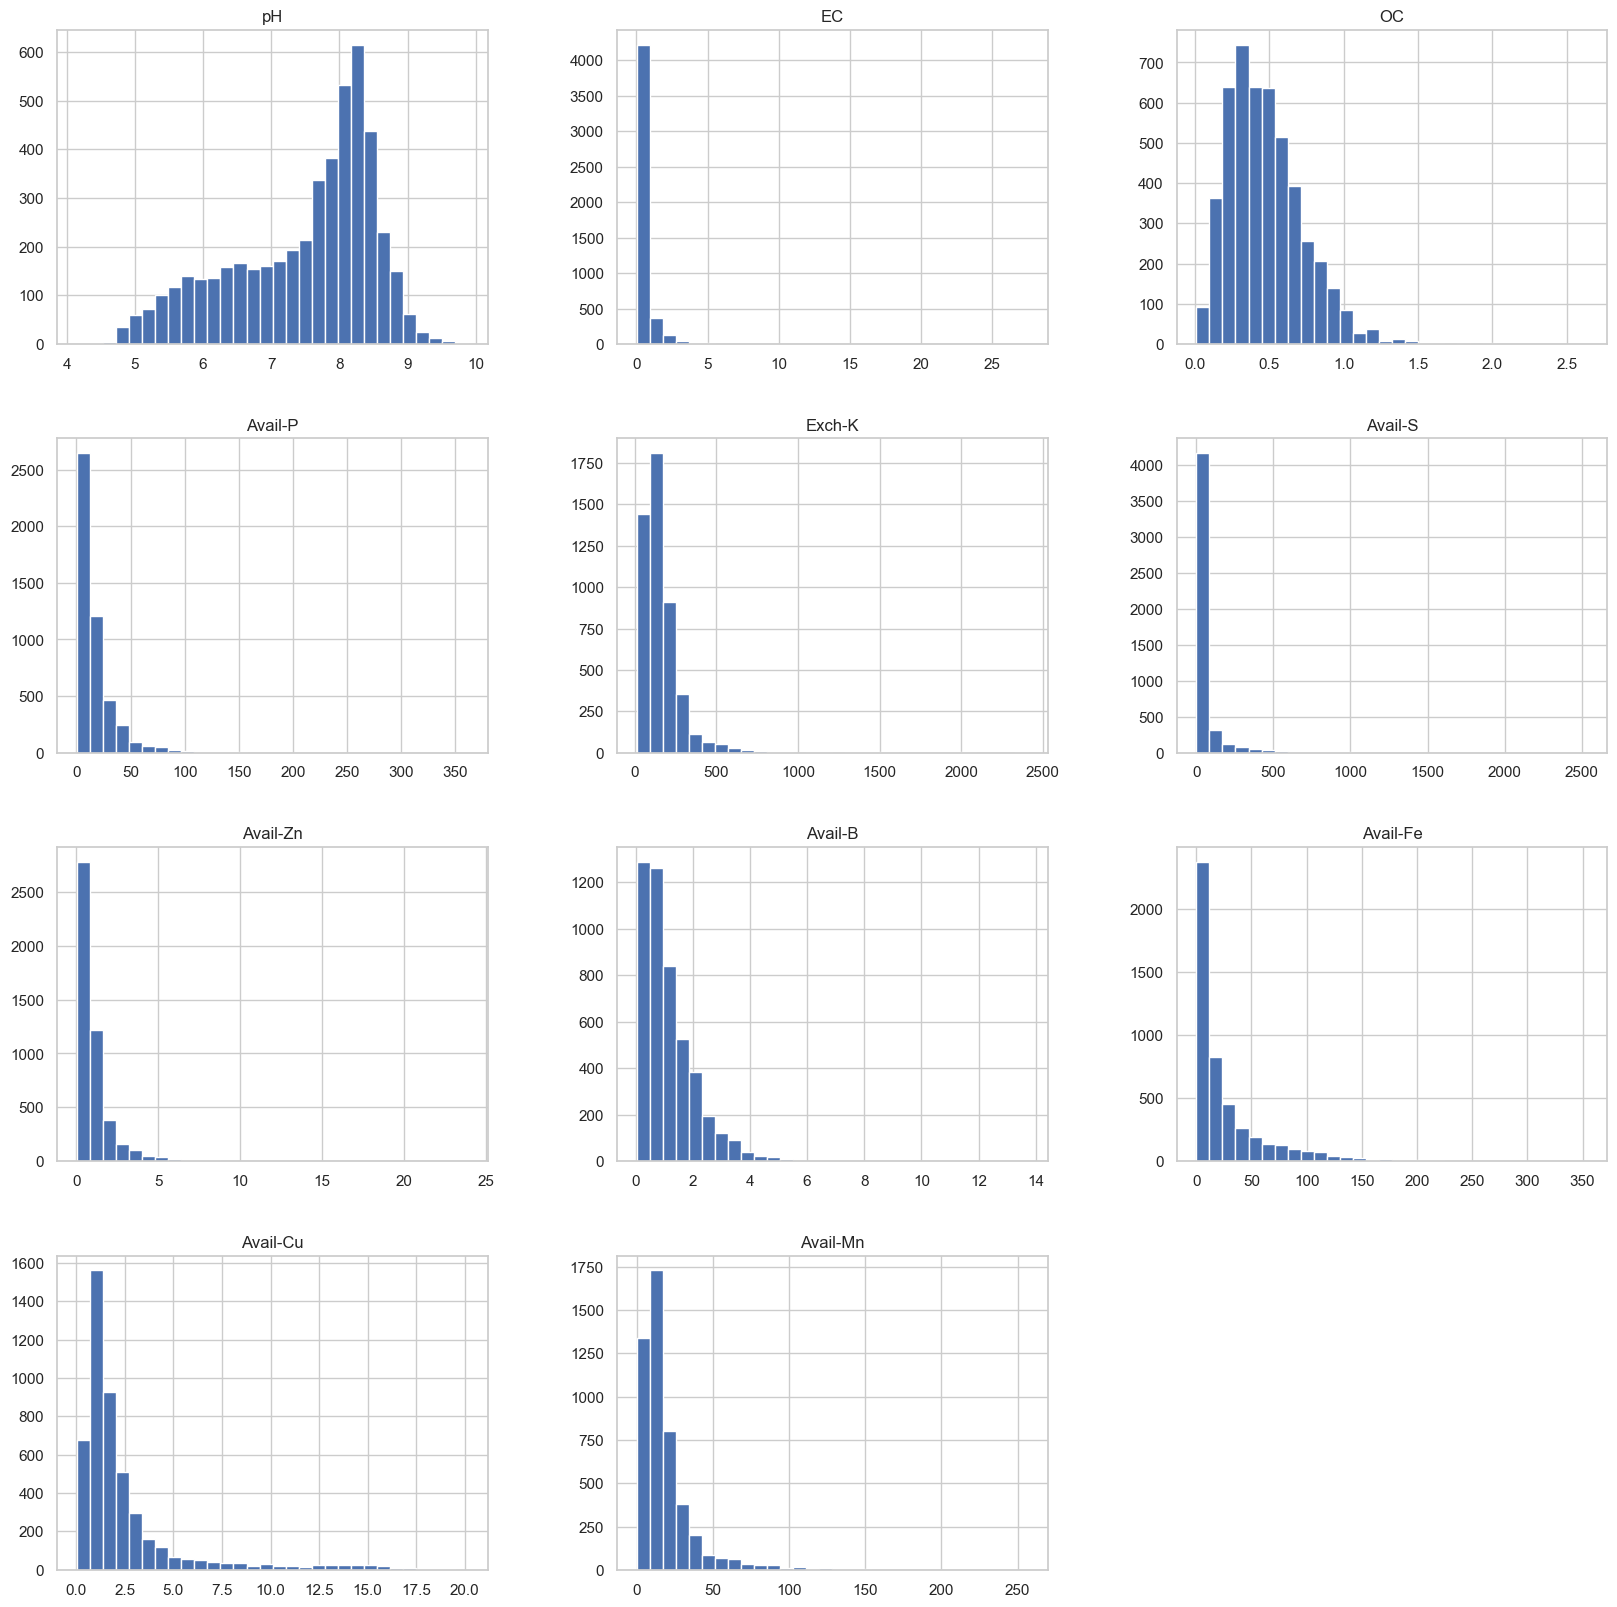

In [42]:
sns.set(style="whitegrid")
nutrient_cols = ['pH', 'EC', 'OC', 'Avail-P', 'Exch-K', 'Avail-S', 'Avail-Zn', 'Avail-B', 'Avail-Fe', 'Avail-Cu', 'Avail-Mn']
df[nutrient_cols].hist(bins=30, figsize =(20,20))
plt.show()

<Axes: >

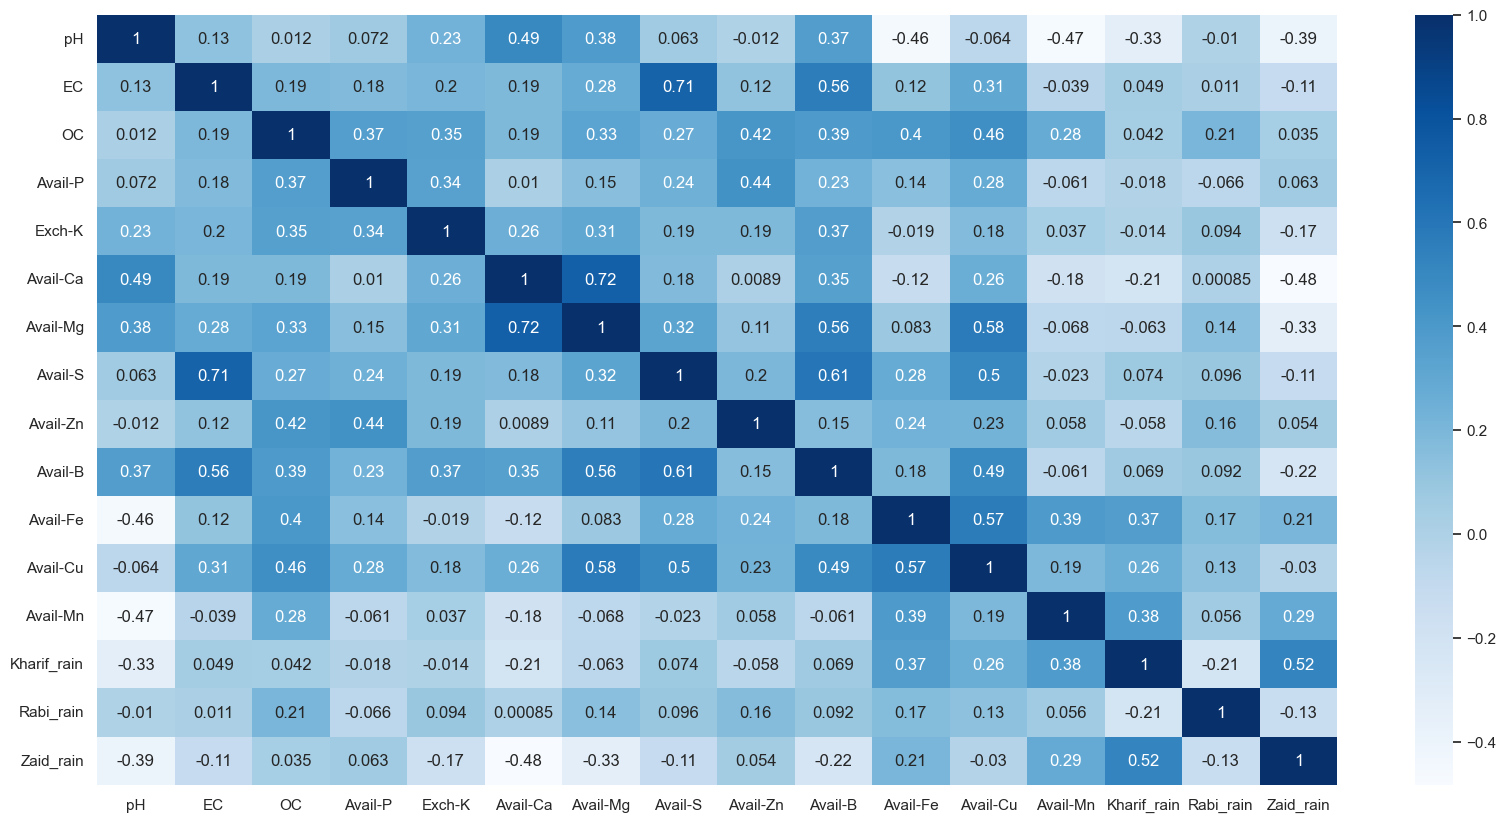

In [43]:
plt.figure(figsize=(20, 10))
sns.heatmap(df[numerical_cols].corr(), cmap="Blues",annot=True)

In [44]:
#Encode 3 categorical variables which need to be converted to numerical format
le = LabelEncoder()  
df['District_encoded']=le.fit_transform(df['District'])
df['Mandal_encoded']=le.fit_transform(df['Mandal'])
df['Village_encoded']=le.fit_transform(df['Village'])
#df['Soil_Type_Standard_encoded']=le.fit_transform(df['Soil_Type_Standard'])
df['First_Crop_encoded']=le.fit_transform(df['First_Crop'])

In [45]:
# Remove Categorical variables
df_new = df.drop(['District', 'Mandal', 'Village', "Soil_Type_Standard" ,"First_Crop"], axis=1)
print(df_new.head().to_string())

     pH    EC    OC  Avail-P  Exch-K  Avail-Ca  Avail-Mg  Avail-S  Avail-Zn  Avail-B  Avail-Fe  Avail-Cu  Avail-Mn  Kharif_rain  Rabi_rain  Zaid_rain  District_encoded  Mandal_encoded  Village_encoded  First_Crop_encoded
0  6.19  0.07  0.18     7.13    41.0     587.0     101.0     5.16      0.30     0.17      8.89      0.51     15.24        272.0      148.0       77.0                 0              17               80                   9
1  8.40  0.33  0.31    10.34   102.0     811.0     261.0     9.91      0.36     0.57      3.24      0.44      6.90        272.0      148.0       77.0                 0              17               80                   9
2  7.10  0.11  0.17     8.46    46.0     582.0      48.0     3.77      0.37     0.19      5.54      0.42      8.34        272.0      148.0       77.0                 0              17               80                   9
3  8.30  0.21  0.20     2.31    35.0    3048.0      52.0     4.14      0.23     0.21      1.79      0.67      4.17  

In [46]:
#Split the dataset into train and test with stratification
X_train, X_test, y_train, y_test = train_test_split(df_new.iloc[:, :-1],df_new.iloc[:, -1],test_size=0.25,random_state=42, stratify=df_new.iloc[:, -1])
y_test_c = y_test.copy(deep=True)

In [47]:
#Data scaling
scaler = StandardScaler()
scaled_train = scaler.fit_transform(X_train.to_numpy())
var_list = list(X_train.columns)
append_str = '_N'
var_list_N = [sub + append_str for sub in var_list]

train_Norm = pd.DataFrame(scaled_train,
                        columns=var_list_N)
X_train_scaled = train_Norm.to_numpy()

scaled_test = scaler.transform(X_test.to_numpy())
test_Norm = pd.DataFrame(scaled_test,
                        columns=var_list_N)
X_test_scaled = test_Norm.to_numpy()


In [48]:

pca = PCA(n_components=X_train_scaled.shape[1]//2+1) ## Limiting # of PCA components to half of X dimensions
print(X_train_scaled.shape)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print("PCA_Reg:", np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4) * 100))
print("This appears to indicate that more than half the features are important to explain the variability in crop selection")

(3612, 19)
PCA_Reg: [22.73 40.51 50.48 57.72 63.91 69.37 74.3  79.19 83.3  86.21]
This appears to indicate that more than half the features are important to explain the variability in crop selection


In [49]:
#import Gaussian NB Classifier

#Setup a gnb classifier
model_nb = GaussianNB()

#Fit the model
# model_nb.fit(X_train_pca, y_train)
# y_pred_nb = model_nb.predict(X_test_pca)

model_nb.fit(X_train_scaled, y_train)
y_pred_nb = model_nb.predict(X_test_scaled)

##Compute accuracy on the training set
print("Gaussian NB Train Accuracy:",model_nb.score(X_train_scaled, y_train))

# #Compute accuracy on the test set
print("Gaussian NB Test Accuracy:",model_nb.score(X_test_scaled, y_test_c))

# #Evaluate NB model
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

model_nb.fit(X_train_pca, y_train)
y_pred_pca_nb = model_nb.predict(X_test_pca)
##Compute accuracy on the training set
print("Gaussian NB Train Accuracy PCA:",model_nb.score(X_train_pca, y_train))

# #Compute accuracy on the test set
print("Gaussian NB Test Accuracy PCA:",model_nb.score(X_test_pca, y_test_c))
# 6. Evaluate PCA model
print("Accuracy:", accuracy_score(y_test, y_pred_pca_nb))
print("Classification Report:\n", classification_report(y_test_c, y_pred_pca_nb))

Gaussian NB Train Accuracy: 0.36129568106312293
Gaussian NB Test Accuracy: 0.3579734219269103
Accuracy: 0.3579734219269103
Classification Report:
               precision    recall  f1-score   support

           0       0.10      0.04      0.06        25
           1       0.00      0.00      0.00        35
           2       0.07      0.25      0.11        12
           3       0.15      0.60      0.24        10
           4       0.44      0.79      0.57        29
           5       0.58      0.89      0.70        28
           6       0.20      0.50      0.29        18
           7       0.57      0.33      0.41       123
           8       0.42      0.94      0.58        52
           9       0.48      0.35      0.41       157
          10       0.13      0.31      0.18        13
          11       0.44      0.11      0.17       103
          12       1.00      0.10      0.18        10
          13       0.27      0.80      0.40        10
          14       0.62      0.18      0.2

In [50]:

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_pca, y_train)
y_pred_rf = rf.predict(X_test_pca)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_pca, y_train)
y_pred_gb = gb.predict(X_test_pca)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Gradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gb))

Random Forest Accuracy: 0.5913621262458472
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.36      0.45        25
           1       0.76      0.37      0.50        35
           2       0.42      0.42      0.42        12
           3       0.29      0.20      0.24        10
           4       0.42      0.45      0.43        29
           5       0.73      0.79      0.76        28
           6       0.20      0.11      0.14        18
           7       0.47      0.55      0.51       123
           8       0.61      0.63      0.62        52
           9       0.61      0.76      0.68       157
          10       0.22      0.15      0.18        13
          11       0.52      0.65      0.58       103
          12       0.00      0.00      0.00        10
          13       0.29      0.20      0.24        10
          14       0.54      0.35      0.43       113
          15       0.86      0.95      0.90        20


## Creating a Forward Selection Strategy for PCA Feature Selection

In [51]:
def plot_complexity_curve(k_list, knn_model, x_train, x_test, y_train, y_test):
    train_scores = []
    test_scores = []
    knn_test_scores = pd.DataFrame()
    # For each k
    for k in k_list:
        # Initialize, fit, predict
        knn = knn_model(k, weights=knn_wt, metric='manhattan')
        knn.fit(x_train, y_train)
        test_scores.append(knn.score(x_test, y_test))
    
    knn_test_scores["K_value"] = pd.Series(k_list)
    knn_test_scores["TestScore"] = pd.Series(test_scores)
    # print("KNN Fit done. Returning DF with scores")
    return knn_test_scores

In [52]:
np.random.seed(12345)
knn_wt = 'distance'


all_res = pd.DataFrame()
all_preds = pd.DataFrame()
#
for i in range(1,X_train_pca.shape[1]+1):
    res=pd.DataFrame()
    preds = pd.DataFrame()
    preds["y_act"] = y_test_c  

    # print( X_train_pca[:, :i].shape,X_test_pca[:, :i].shape, y_train.shape,
    #                                 y_test.shape)
    # ## KNN Classifier
    k_score = plot_complexity_curve(range(1,50), KNeighborsClassifier, X_train_pca[:, :i], X_test_pca[:, :i], y_train,
                                    y_test_c)
    k_df = k_score[k_score["TestScore"] >= 0.995 * k_score["TestScore"].max()]
    k_opt = int(k_df["K_value"].min())
    knn_model = KNeighborsClassifier(n_neighbors=k_opt, weights=knn_wt, metric='manhattan').fit(X_train_pca[:, :i],
                                                                                               y_train)
    # Score
    y_pred_knn = knn_model.predict(X_test_pca[:, :i])
    knn_accuracy = np.round(accuracy_score(y_test_c, y_pred_knn),4)

    #Setup a gnb classifier
    model_nb = GaussianNB()

    model_nb.fit(X_train_pca[:, :i], y_train)
    y_pred_nb = model_nb.predict(X_test_pca[:, :i])
    nb_accuracy = np.round(accuracy_score(y_test_c, y_pred_nb),4)

    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train_pca[:, :i], y_train)
    y_pred_rf = rf.predict(X_test_pca[:, :i])
    rf_accuracy = np.round(accuracy_score(y_test_c, y_pred_rf),4)

    
    ##Gradient Boosting
    gb = GradientBoostingClassifier(random_state=42)
    gb.fit(X_train_pca[:, :i], y_train)
    y_pred_gb = gb.predict(X_test_pca[:, :i])
    gb_accuracy = np.round(accuracy_score(y_test_c, y_pred_gb),4)


    ### logistic Regression
    LR = LogisticRegression(
    # multi_class='multinomial',  # Use 'multinomial' for softmax regression
    solver='lbfgs',             # Solver that supports multinomial
    max_iter=1000)
    LR.fit(X_train_pca[:, :i], y_train)
    # Predict
    y_pred_LR = LR.predict(X_test_pca[:, :i])
    LR_accuracy = np.round(accuracy_score(y_test_c, y_pred_LR),4)


        
    preds["KNN_pred"] = y_pred_knn
    preds["NB_pred"] = y_pred_nb
    preds["RF_pred"] = y_pred_rf
    preds["GB_pred"] = y_pred_gb
    preds["LR_pred"] = y_pred_LR
    preds["PCA_Cols"] = i  


    res["PCA_Cols"]=pd.Series(i)
    res["Knn_Kopt"]=pd.Series(k_opt)
    res["Knn_Acc"]=pd.Series(knn_accuracy)
    res["NaiveBayes_Acc"]=pd.Series(nb_accuracy)
    res["RF_Acc"]=pd.Series(rf_accuracy)
    res["GB_Acc"]=pd.Series(gb_accuracy)
    res["LogReg_Acc"]=pd.Series(LR_accuracy)
    
    all_res = pd.concat([all_res,res],ignore_index=True)
    all_preds = pd.concat([all_preds,preds],ignore_index=True)
    print("PCA Cols:",str(i), "Knn:",k_opt, knn_accuracy, "Naive Bayes:",nb_accuracy, "Random Forest:",rf_accuracy,"Gradient Boost", gb_accuracy,"Logistic Regression:",LR_accuracy)




PCA Cols: 1 Knn: 38 0.2159 Naive Bayes: 0.2915 Random Forest: 0.1719 Gradient Boost 0.2375 Logistic Regression: 0.304
PCA Cols: 2 Knn: 41 0.3812 Naive Bayes: 0.3355 Random Forest: 0.3115 Gradient Boost 0.3372 Logistic Regression: 0.3488
PCA Cols: 3 Knn: 27 0.49 Naive Bayes: 0.3663 Random Forest: 0.4659 Gradient Boost 0.4111 Logistic Regression: 0.3821
PCA Cols: 4 Knn: 14 0.5399 Naive Bayes: 0.3978 Random Forest: 0.539 Gradient Boost 0.4801 Logistic Regression: 0.4161
PCA Cols: 5 Knn: 19 0.5573 Naive Bayes: 0.4219 Random Forest: 0.5515 Gradient Boost 0.4917 Logistic Regression: 0.4286
PCA Cols: 6 Knn: 21 0.5789 Naive Bayes: 0.4219 Random Forest: 0.5731 Gradient Boost 0.5091 Logistic Regression: 0.4618
PCA Cols: 7 Knn: 9 0.6005 Naive Bayes: 0.4336 Random Forest: 0.5839 Gradient Boost 0.5415 Logistic Regression: 0.4593
PCA Cols: 8 Knn: 22 0.5963 Naive Bayes: 0.4228 Random Forest: 0.6047 Gradient Boost 0.5316 Logistic Regression: 0.4867
PCA Cols: 9 Knn: 16 0.608 Naive Bayes: 0.4277 Random 

### Plotting of results

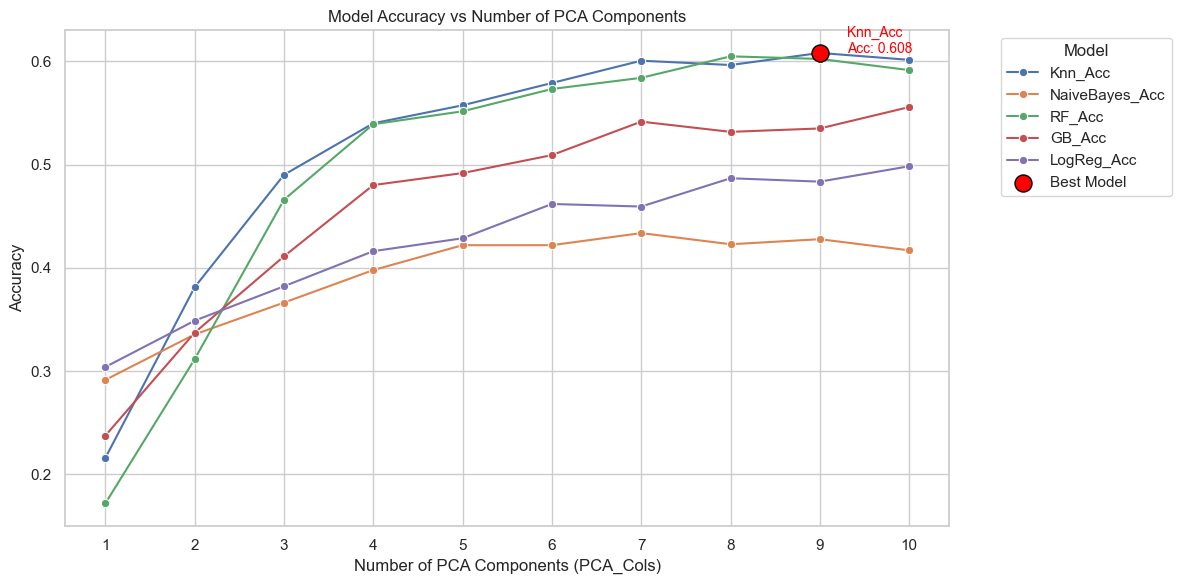

In [53]:
all_preds.to_csv("y_test_with_pred.csv")
all_res.to_csv("All_results.csv")

# Melt the dataframe to long format
all_res_melted = all_res.melt(
    id_vars="PCA_Cols",
    value_vars=["Knn_Acc", "NaiveBayes_Acc", "RF_Acc", "GB_Acc", "LogReg_Acc"],
    var_name="Model",
    value_name="Accuracy"
)

# Find the best model/component (highest accuracy)
best_row = all_res_melted.loc[all_res_melted["Accuracy"].idxmax()]
best_x = best_row["PCA_Cols"]
best_y = best_row["Accuracy"]
best_model = best_row["Model"]

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=all_res_melted, x="PCA_Cols", y="Accuracy", hue="Model", marker="o")

# Highlight the best point
plt.scatter(best_x, best_y, color='red', s=150, edgecolor='black', zorder=5, label="Best Model")

# Annotate the best point
plt.text(best_x + 0.3, best_y, f'{best_model}\nAcc: {best_y}', color='red', fontsize=10)

# Add titles and labels
plt.title("Model Accuracy vs Number of PCA Components")
plt.xlabel("Number of PCA Components (PCA_Cols)")
plt.ylabel("Accuracy")
plt.xticks(all_res['PCA_Cols'].unique())
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Create Soft voting Ensemble Model

In [57]:
###Selected from previous PCA Feature selection
best_x = 9
k_opt = 16
knn = KNeighborsClassifier(n_neighbors=k_opt, weights='distance', metric='manhattan')
# nb = GaussianNB()
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
# lr = LogisticRegression(solver='lbfgs', max_iter=1000)

ensemble = VotingClassifier(
    estimators=[
        ('KNN', knn),
        # ('NB', nb),
        ('RF', rf),
        ('GB', gb),
        # ('LR', lr)
    ],
    voting='soft'  
)

# Fit on training data
ensemble.fit(X_train_pca[:, :best_x], y_train)  # best_x from earlier (optimal PCA cols)

# Predict and evaluate
y_pred_ensemble = ensemble.predict(X_test_pca[:, :best_x])
ensemble_accuracy = accuracy_score(y_test_c, y_pred_ensemble)

print(f"Ensemble Accuracy: {np.round(ensemble_accuracy, 4)}")
print("Ensemble Classification Report:\n", classification_report(y_test, y_pred_ensemble))

Ensemble Accuracy: 0.5988
Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.44      0.52        25
           1       0.70      0.40      0.51        35
           2       0.62      0.42      0.50        12
           3       0.25      0.30      0.27        10
           4       0.50      0.45      0.47        29
           5       0.74      0.71      0.73        28
           6       0.14      0.06      0.08        18
           7       0.49      0.57      0.52       123
           8       0.61      0.73      0.67        52
           9       0.59      0.76      0.67       157
          10       0.40      0.31      0.35        13
          11       0.52      0.65      0.58       103
          12       0.00      0.00      0.00        10
          13       0.50      0.50      0.50        10
          14       0.57      0.36      0.44       113
          15       0.86      0.95      0.90        20
          16       0.5